<a href="https://colab.research.google.com/github/Shazidul-Alam/MNIST-dataset-Classification/blob/main/MNIST_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader 
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
image,label=dataset[0]
print('image.shape:',image.shape)
image[0].shape

image.shape: torch.Size([1, 28, 28])


torch.Size([28, 28])

label: 5


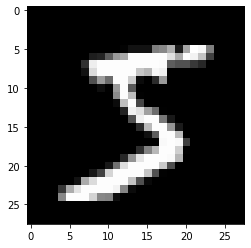

In [ ]:
plt.imshow(image[0],cmap='gray')
print('label:',label)

In [ ]:
val_size=10000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [ ]:
batch_size=128

In [ ]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True)
val_loader=DataLoader(val_ds,batch_size*2)

images.shape: torch.Size([128, 1, 28, 28])


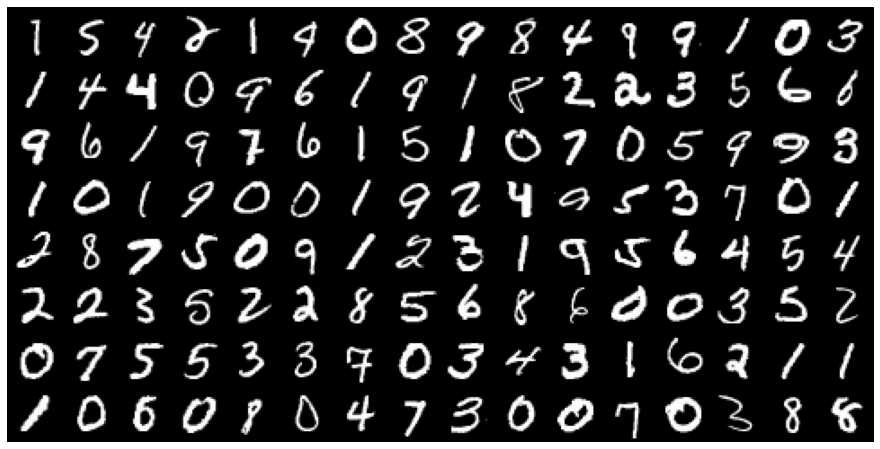

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16, 8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break


In [ ]:
for images,labels in train_loader:
  print('images.shape:',images.shape)
  inputs=images.reshape(-1,784)
  print('input shapes:' ,inputs.shape)
  break

images.shape: torch.Size([128, 1, 28, 28])
input shapes: torch.Size([128, 784])


In [ ]:
input_size=inputs.shape[-1]
hidden_size=32

In [ ]:
layer1=nn.Linear(input_size,hidden_size)

In [ ]:
layer1_outputs=layer1(inputs)
print('layer1_outputs.shape:',layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [ ]:
relu_outputs=F.relu(layer1_outputs)

In [ ]:
output_size=10
layer2=nn.Linear(hidden_size,output_size)

In [ ]:
layer2_outputs=layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [ ]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.3032, grad_fn=<NllLossBackward0>)

###Model

In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [ ]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.317831516265869
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0988,  0.0530, -0.0547,  0.1191,  0.0878, -0.1689,  0.0636,  0.0267,
         -0.0726, -0.0859],
        [-0.0925,  0.0246,  0.0733,  0.1876,  0.0621, -0.1771,  0.0493, -0.1047,
         -0.0909, -0.0503]])


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([0, 8, 9, 7, 1, 5, 1, 7, 6, 0, 3, 5, 1, 8, 1, 0, 6, 0, 7, 9, 3, 4, 2, 1,
        7, 3, 1, 5, 5, 1, 4, 4, 1, 6, 5, 8, 5, 5, 8, 0, 6, 8, 7, 5, 0, 9, 4, 4,
        6, 7, 5, 4, 0, 5, 9, 0, 9, 5, 0, 8, 3, 4, 3, 8, 7, 1, 5, 6, 7, 1, 3, 1,
        5, 0, 5, 3, 6, 2, 0, 6, 6, 3, 6, 6, 9, 6, 9, 4, 7, 4, 8, 2, 8, 7, 1, 8,
        9, 9, 9, 1, 9, 1, 5, 8, 4, 1, 5, 1, 7, 5, 7, 6, 5, 6, 6, 0, 2, 2, 3, 4,
        0, 1, 1, 2, 9, 0, 6, 2, 3, 1, 6, 6, 8, 6, 4, 8, 0, 8, 7, 1, 3, 0, 8, 1,
        3, 2, 7, 5, 5, 0, 5, 7, 0, 6, 1, 3, 4, 9, 9, 7, 5, 0, 6, 7, 0, 0, 8, 8,
        6, 9, 1, 3, 0, 6, 6, 6, 9, 7, 2, 2, 5, 0, 1, 4, 8, 9, 4, 3, 9, 4, 6, 4,
        7, 3, 6, 3, 9, 2, 6, 7, 1, 0, 0, 0, 9, 5, 6, 7, 8, 7, 0, 1, 1, 6, 8, 7,
        3, 7, 5, 4, 6, 6, 6, 2, 4, 3, 2, 9, 9, 6, 4, 2, 7, 9, 5, 2, 6, 0, 4, 8,
        4, 5, 3, 2, 1, 9, 7, 8, 3, 0, 5, 8, 6, 7, 9, 5], device='cuda:0')


In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.317573308944702, 'val_acc': 0.09091796725988388}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2174, val_acc: 0.9354
Epoch [1], val_loss: 0.1857, val_acc: 0.9434
Epoch [2], val_loss: 0.1522, val_acc: 0.9522
Epoch [3], val_loss: 0.1514, val_acc: 0.9523
Epoch [4], val_loss: 0.1362, val_acc: 0.9593


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1203, val_acc: 0.9635
Epoch [1], val_loss: 0.1188, val_acc: 0.9634
Epoch [2], val_loss: 0.1203, val_acc: 0.9630
Epoch [3], val_loss: 0.1175, val_acc: 0.9641
Epoch [4], val_loss: 0.1180, val_acc: 0.9638


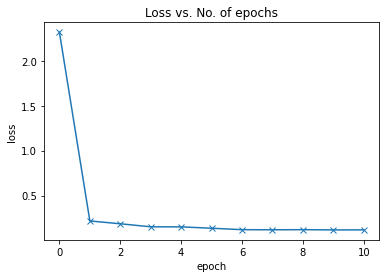

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

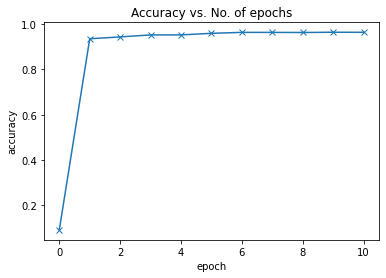

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 3 , Predicted: 3


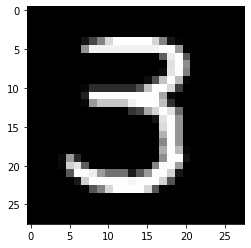

In [ ]:
img, label = test_dataset[4532]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10068366676568985, 'val_acc': 0.970996081829071}

In [ ]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')